In [1]:
'''
this got stuck with what seems like GPU memory error

InternalError: Failed copying input tensor from 
/job:localhost/replica:0/task:0/device:CPU:0 to 
/job:localhost/replica:0/task:0/device:GPU:0 in 
order to run _EagerConst: Dst tensor is not initialized.

'''

'\nthis got stuck with what seems like GPU memory error\n\nInternalError: Failed copying input tensor from \n/job:localhost/replica:0/task:0/device:CPU:0 to \n/job:localhost/replica:0/task:0/device:GPU:0 in \norder to run _EagerConst: Dst tensor is not initialized.\n\n'

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # trying disabling GPU

import tensorflow as tf
import segmentation_models as sm
import time
import cv2
import random

import numpy as np
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard

Segmentation Models: using `keras` framework.


In [2]:
local_weights_path = r"resnet34_imagenet_1000_no_top.h5"

In [2]:

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

SIZE_X = 640
SIZE_Y = 480

train_images = []
train_masks = []

rgb_path = 'out_sem/rgb_sample'
msk_path = 'out_sem/msk_sample'

rgb_images = os.listdir(rgb_path)

random.shuffle(rgb_images)

for file in rgb_images:
        pth = os.path.join(rgb_path,file) 
        img = cv2.imread(pth,cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (SIZE_X,SIZE_Y))
        train_images.append(img/255)
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,0)
        #msk = cv2.resize(msk, (SIZE_X,SIZE_Y))
        train_masks.append(msk/255)
        
train_images = np.array(train_images)
X = tf.cast(train_images, tf.float32)
del(train_images)

train_masks = np.array(train_masks)
Y = tf.cast(train_masks, tf.float32)
del(train_masks)
X=np.asarray(X)
Y=np.asarray(Y)
X_train, X_val, Y_train, Y_val = train_test_split(X,Y,test_size=0.2,random_state=42)

del(X)
del(Y)

X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)




In [3]:
X_train.shape

(76, 480, 640, 3)

In [4]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
Y_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

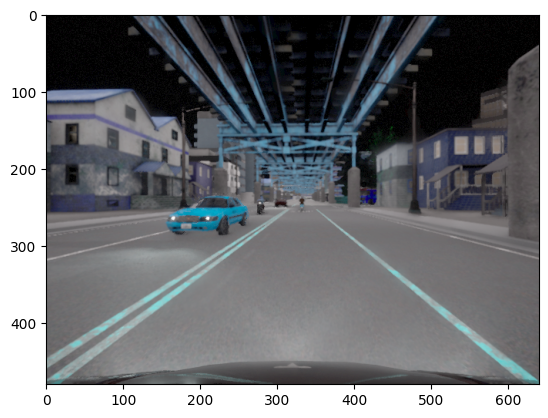

In [6]:
plt.imshow(X_train[0])

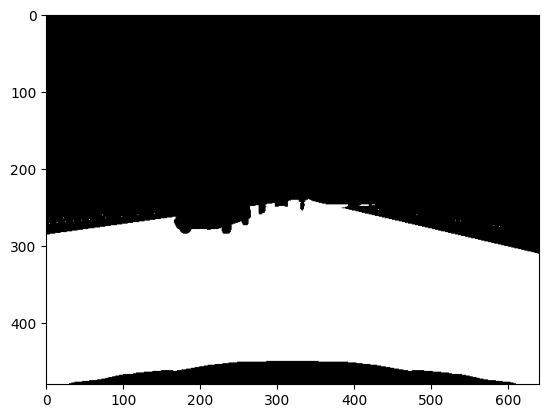

In [7]:
plt.imshow(Y_train[0],cmap='gray')

In [8]:
local_weights_path = r"resnet34_imagenet_1000_no_top.h5"
NAME = "UNET_640_480-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
# Initialize and compile the model
model = sm.Unet(BACKBONE, encoder_weights=None)
model.load_weights(local_weights_path, by_name=True, skip_mismatch=True)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
#model.summary()

In [9]:

   
history = model.fit(X_train,Y_train,batch_size=1,epochs=50,verbose=1,validation_data=(X_val,Y_val),callbacks=[tensorboard])

Epoch 1/50
76/76 [==============================] - 21s 166ms/step - loss: 0.1498 - mse: 0.0403 - val_loss: 6.0089 - val_mse: 0.3932
Epoch 2/50
76/76 [==============================] - 12s 159ms/step - loss: 0.0459 - mse: 0.0112 - val_loss: 1.7740 - val_mse: 0.3690
Epoch 3/50
76/76 [==============================] - 12s 160ms/step - loss: 0.0476 - mse: 0.0124 - val_loss: 0.7657 - val_mse: 0.2251
Epoch 4/50
76/76 [==============================] - 12s 160ms/step - loss: 0.0353 - mse: 0.0093 - val_loss: 3.4130 - val_mse: 0.3767
Epoch 5/50
76/76 [==============================] - 12s 161ms/step - loss: 0.0612 - mse: 0.0169 - val_loss: 2.3838 - val_mse: 0.3877
Epoch 6/50
76/76 [==============================] - 12s 163ms/step - loss: 0.0351 - mse: 0.0096 - val_loss: 1.4938 - val_mse: 0.3177
Epoch 7/50
76/76 [==============================] - 12s 163ms/step - loss: 0.0316 - mse: 0.0085 - val_loss: 2.2954 - val_mse: 0.5608
Epoch 8/50
76/76 [==============================] - 12s 164ms/step - 

In [10]:
model.save("data_95_ep_50.h5")

In [11]:
print(X_train.shape,' vs.',Y_train.shape)

(76, 480, 640, 3)  vs. (76, 480, 640)


In [13]:
y_te = model.predict(X_train[:1])

1/1 [==============================] - 0s 457ms/step


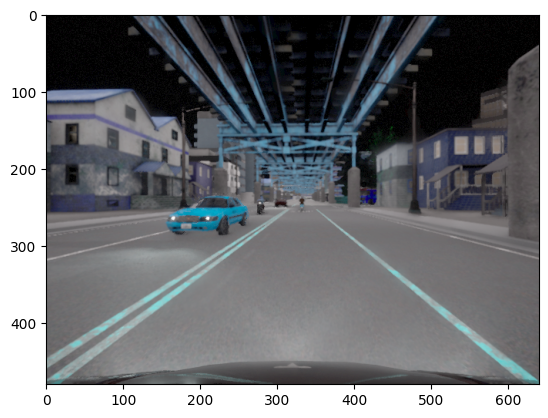

In [20]:
plt.imshow(X_train[0])

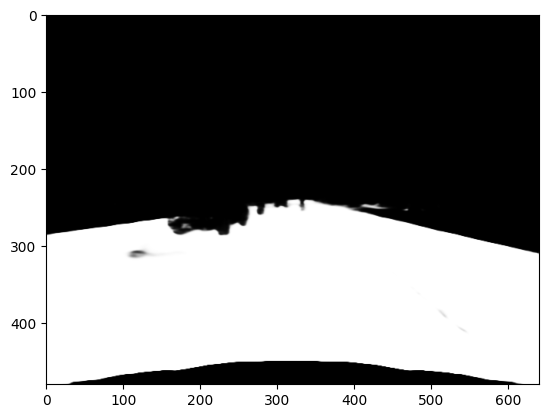

In [19]:
plt.imshow(y_te[0],cmap="gray")

In [ ]:
from keras.utils import plot_model
from keras import backend as K
import numpy as np

input_shape = (SIZE_Y,SIZE_X,3)
#print(model.summary())

def get_mem_usg(batch_size,model):
    features_mem = 0
    float_bytes = 4.0
    for layer in model.layers:
        out_shape = layer.output_shape
        if type(out_shape) is list:
            out_shape= out_shape[0]
        else:
            out_shape = [out_shape[1],out_shape[2],out_shape[3]]
        single_layer_mem = 1
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *=s
        single_layer_mem_float = single_layer_mem * float_bytes
        single_layer_mem_MB = single_layer_mem_float /(1024**2)
        print("memory for", out_shape," layer in MB is: ",single_layer_mem_MB)
        features_mem += single_layer_mem_MB
    trainable_wts = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_wts = np.sum([K.count_params(p) for p in model.non_trainable_weights])
    parameter_mem_MB =((trainable_wts+non_trainable_wts) * float_bytes)/(1024**2)
    print("_____________________________________")
    print("Memory for features in MB is: ", features_mem * batch_size)
    print("Memory for parameters in MB is: %.2f" %parameter_mem_MB)
    total_memory_MB = (batch_size * features_mem) + parameter_mem_MB
    total_memory_GB = total_memory_MB/1024
    return total_memory_GB

mem_for_my_model = get_mem_usg(16,model)
print("_____________________________________")
print("Min memory for my model in GB is: %.2f" %mem_for_my_model)

In [ ]:
# code for estimating memory requirements of the model

from keras.utils.vis_utils import plot_model
from keras import backend as K
import numpy as np


input_image_shape = (SIZE_X,SIZE_Y,3)

print(model.summary())


def get_model_memory_usage(batch_size, model):
    
    features_mem = 0 # Initialize memory for features. 
    float_bytes = 4.0 #Multiplication factor as all values we store would be float32.
    
    for layer in model.layers:

        out_shape = layer.output_shape
        
        if type(out_shape) is list:   #e.g. input layer which is a list
            out_shape = out_shape[0]
        else:
            out_shape = [out_shape[1], out_shape[2], out_shape[3]]
            
        #Multiply all shapes to get the total number per layer.    
        single_layer_mem = 1 
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        
        single_layer_mem_float = single_layer_mem * float_bytes #Multiply by 4 bytes (float)
        single_layer_mem_MB = single_layer_mem_float/(1024**2)  #Convert to MB
        
        print("Memory for", out_shape, " layer in MB is:", single_layer_mem_MB)
        features_mem += single_layer_mem_MB  #Add to total feature memory count

# Calculate Parameter memory
    trainable_wts = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_wts = np.sum([K.count_params(p) for p in model.non_trainable_weights])
    parameter_mem_MB = ((trainable_wts + non_trainable_wts) * float_bytes)/(1024**2)
    print("_________________________________________")
    print("Memory for features in MB is:", features_mem*batch_size)
    print("Memory for parameters in MB is: %.2f" %parameter_mem_MB)

    total_memory_MB = (batch_size * features_mem) + parameter_mem_MB  #Same number of parameters. independent of batch size

    total_memory_GB = total_memory_MB/1024
    
    return total_memory_GB

#####################################################################

mem_for_my_model = get_model_memory_usage(16, model)

print("_________________________________________")
print("Minimum memory required to work with this model is: %.2f" %mem_for_my_model, "GB")

In [30]:
#plot_model(model)

In [31]:

rgb_path = 'out_sem/rgb_sample'
msk_path = 'out_sem/msk_sample'

rgb_images = os.listdir(rgb_path)

random.shuffle(rgb_images)

for file in rgb_images[0:1]:
        pth = os.path.join(rgb_path,file) 
        img = cv2.imread(pth,cv2.IMREAD_COLOR)
        print('rgb shape',img.shape)
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,0)
        print('mask shape',msk.shape)
        

rgb shape (480, 640, 3)
mask shape (480, 640)


In [22]:
model.save('model/{}'.format(NAME),save_format='tf')

INFO:tensorflow:Assets written to: model/UNET_640_480-1719844976\assets


INFO:tensorflow:Assets written to: model/UNET_640_480-1719844976\assets


In [24]:
#test on in train/val images from simulator
from keras.models import load_model
SIZE_X = 640
SIZE_Y = 480
NAME = "UNET_640_480-1719844976"

model = load_model("model/{}".format(NAME),compile=False)

rgb_path = 'out_sem/rgb_sample'
rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)
for file in rgb_images:
    pth = os.path.join(rgb_path,file) 
    frame = cv2.imread(pth,cv2.IMREAD_COLOR)
    frame = cv2.resize(frame, (SIZE_X,SIZE_Y))
    frame = cv2.flip(frame, 1)
    img = np.float32(frame /255)
    input_for_model = img[ :, :, None] 
    input_for_model = np.expand_dims(img, axis=0)
    mask = model(input_for_model,training=False)
    final_mask = (np.squeeze(mask[0].numpy()) * 255)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    result = cv2.bitwise_and(gray,gray,mask = final_mask.astype(np.uint8))
    cv2.imshow('predicted mask',result)
    # Press Q on keyboard to  exit
    if cv2.waitKey(2000) & 0xFF == ord('q'):
        break
 
       
# Closes all the frames
cv2.destroyAllWindows()

In [3]:
# start new model training full code - THIS CREATED ALL IN MASK _ FAILURE
# Lane marking only
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # trying disabling GPU

import tensorflow as tf
import segmentation_models as sm
import time
import cv2
import random

import numpy as np
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

SIZE_X = 640
SIZE_Y = 480

validation_portion = 0.2
sample_size_limit = 100

rgb_path = 'out_sem/rgb'
msk_path = 'out_sem/msk_ln'

rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)

#reduce number of images here
rgb_images = rgb_images[0:sample_size_limit]

img_count = len(rgb_images)
print(img_count)

train_len = int(img_count * (1-validation_portion))
val_len = img_count - train_len

x_train = np.zeros(shape=(train_len,SIZE_Y,SIZE_X,3),dtype=np.float16)
x_val = np.zeros(shape=(val_len,SIZE_Y,SIZE_X,3),dtype=np.float16)

y_train =  np.zeros(shape=(train_len,SIZE_Y,SIZE_X),dtype=np.float16)
y_val =  np.zeros(shape=(val_len,SIZE_Y,SIZE_X),dtype=np.float16)

i = 0
i_val = 0
for file in rgb_images:
        pth = os.path.join(rgb_path,file) 
    
        img = cv2.imread(pth,cv2.IMREAD_COLOR)
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,0)
        #print(i)

        #print(msk)
        #img = cv2.resize(img, (SIZE_X,SIZE_Y))
        #msk = cv2.resize(msk, (SIZE_X,SIZE_Y))
        
        if i < train_len:
            x_train[i] = img/255
            y_train[i] = msk/255
        else:
            x_val[i_val] = img/255
            y_val[i_val] = msk/255
            i_val += 1
        
        i += 1
        
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# run without GPU
NAME = "UNET_LANES_640_480-{}".format(int(time.time()))
#tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
model = sm.Unet(BACKBONE, encoder_weights=None)
model.load_weights(local_weights_path, by_name=True, skip_mismatch=True)

model.compile(optimizer='adam',loss=sm.losses.BinaryFocalLoss(),metrics=['mse'])
#model.summary()

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

history = model.fit(x_train,y_train,batch_size=1,epochs=50,verbose=1,validation_data=(x_val,y_val))
model.save('model/{}'.format(NAME),save_format='tf')

100
Epoch 1/50
80/80 [==============================] - 21s 161ms/step - loss: 0.0159 - mse: 0.0527 - val_loss: 0.0240 - val_mse: 0.0867
Epoch 2/50
80/80 [==============================] - 12s 153ms/step - loss: 0.0047 - mse: 0.0220 - val_loss: 0.0144 - val_mse: 0.0381
Epoch 3/50
80/80 [==============================] - 12s 155ms/step - loss: 0.0037 - mse: 0.0168 - val_loss: 0.0213 - val_mse: 0.0315
Epoch 4/50
80/80 [==============================] - 13s 157ms/step - loss: 0.0032 - mse: 0.0142 - val_loss: 0.0194 - val_mse: 0.0317
Epoch 5/50
80/80 [==============================] - 12s 155ms/step - loss: 0.0033 - mse: 0.0139 - val_loss: 0.0237 - val_mse: 0.0305
Epoch 6/50
80/80 [==============================] - 12s 155ms/step - loss: 0.0032 - mse: 0.0124 - val_loss: 0.0249 - val_mse: 0.0344
Epoch 7/50
80/80 [==============================] - 12s 156ms/step - loss: 0.0030 - mse: 0.0127 - val_loss: 0.0140 - val_mse: 0.0347
Epoch 8/50
80/80 [==============================] - 13s 157ms/ste

INFO:tensorflow:Assets written to: model/UNET_LANES_640_480-1720029229\assets


INFO:tensorflow:Assets written to: model/UNET_LANES_640_480-1720029229\assets


In [6]:
# use the model just trained



from keras.models import load_model
import cv2

SIZE_X = 640
SIZE_Y = 480
NAME = "UNET_LANES_640_480-1720029229"

model = load_model("model/{}".format(NAME),compile=False)


rgb_path = 'out_sem/rgb'
rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)
for file in rgb_images:
    pth = os.path.join(rgb_path,file) 
    frame = cv2.imread(pth,cv2.IMREAD_COLOR)
    frame = cv2.resize(frame, (SIZE_X,SIZE_Y))
    frame = cv2.flip(frame, 1)
    img = np.float32(frame /255)
    input_for_model = img[ :, :, None] 
    input_for_model = np.expand_dims(img, axis=0)
    mask = model(input_for_model,training=False)
    final_mask = (np.squeeze(mask[0].numpy()) * 255)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    result = cv2.bitwise_and(gray,gray,mask = final_mask.astype(np.uint8))
    cv2.imshow('predicted mask',result)
    # Press Q on keyboard to  exit
    if cv2.waitKey(2000) & 0xFF == ord('q'):
        break
 
       
# Closes all the frames
cv2.destroyAllWindows()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [1]:
# ALL masks attempt as a regression
# added 3 colours for second run
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # trying disabling GPU

import tensorflow as tf
import segmentation_models as sm
import cv2
import random
import time
import numpy as np


BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

SIZE_X = 640
SIZE_Y = 480

validation_portion = 0.2
sample_size_limit = 2_000

rgb_path = 'out_sem/rgb'
msk_path = 'out_sem/sem'

rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)

#reduce number of images here
rgb_images = rgb_images[0:sample_size_limit]

img_count = len(rgb_images)

train_len = int(img_count * (1-validation_portion))
val_len = img_count - train_len

x_train = np.zeros(shape=(train_len,SIZE_Y,SIZE_X,3),dtype=np.float16)
x_val = np.zeros(shape=(val_len,SIZE_Y,SIZE_X,3),dtype=np.float16)

y_train =  np.zeros(shape=(train_len,SIZE_Y,SIZE_X,3),dtype=np.float16)
y_val =  np.zeros(shape=(val_len,SIZE_Y,SIZE_X,3),dtype=np.float16)

i = 0
i_val = 0
for file in rgb_images:
        pth = os.path.join(rgb_path,file) 
        img = cv2.imread(pth,cv2.IMREAD_COLOR)
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (SIZE_X,SIZE_Y))
        #msk = cv2.resize(msk, (SIZE_X,SIZE_Y))
        
        if i < train_len:
            x_train[i] = img/255
            y_train[i] = msk/255
        else:
            x_val[i_val] = img/255
            y_val[i_val] = msk/255
            i_val += 1
        
        i += 1
        
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# run without GPU
NAME = "UNET_ALL_REGR_640_480-{}".format(int(time.time()))
#tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError())
#model.summary()

history = model.fit(x_train,y_train,batch_size=32,epochs=2,verbose=1,validation_data=(x_val,y_val))
model.save('model/{}'.format(NAME),save_format='tf')

Segmentation Models: using `keras` framework.
Epoch 1/2
50/50 [==============================] - 3520s 70s/step - loss: 0.0318 - val_loss: 0.1144
Epoch 2/2
50/50 [==============================] - 3492s 70s/step - loss: 0.0289 - val_loss: 0.0390


INFO:tensorflow:Assets written to: model/UNET_ALL_REGR_640_480-1680058544\assets


INFO:tensorflow:Assets written to: model/UNET_ALL_REGR_640_480-1680058544\assets


In [7]:
# apply model on random images

import tensorflow as tf
from tensorflow.keras.models import load_model
import time
import cv2
import random
import os
import numpy as np

SIZE_X = 640
SIZE_Y = 480

#first
NAME = "UNET_640_480-1679375664"
#lanes
#NAME = "UNET_LANES_640_480-1679951659"
#latest
#NAME = "UNET_LANES_640_480-1679951659"
model = load_model("model/{}".format(NAME),compile=False)

rgb_path = 'c:/SelfDrive/Semantic Segmentation/out_sem/rgb'
rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)
for file in rgb_images:
    pth = os.path.join(rgb_path,file) 
    frame = cv2.imread(pth,cv2.IMREAD_COLOR)
    frame = cv2.resize(frame, (SIZE_X,SIZE_Y))
    img = np.float32(frame /255)
    input_for_model = img[ :, :, None] 
    input_for_model = np.expand_dims(img, axis=0)
    mask = model(input_for_model,training=False)
    final_mask = (np.squeeze(mask[0].numpy()) * 255)
   
    cv2.imshow('initial image',frame)
    cv2.waitKey(2000)
    cv2.imshow('predicted mask',final_mask)
    # Press Q on keyboard to  exit
    if cv2.waitKey(2000) & 0xFF == ord('q'):
        break
 
       
# Closes all the frames
cv2.destroyAllWindows()

In [8]:
# Investigation
### The final issue is - the model only gives one dimension rather than 3
# checked original working model output - also give non-integer

(None, None, None, 1)

In [7]:
# trying to measure how imbalanced lane masks are:
SIZE_X = 640
SIZE_Y = 480
msk_path = 'out_sem/msk_ln'
msk_images = os.listdir(msk_path)
img_count = len(msk_images)
x =  np.zeros(shape=(img_count,SIZE_Y,SIZE_X),dtype=np.float16)

i = 0
for file in msk_images:
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,0)
        x[i] = msk/255
        i += 1
        


In [8]:
np.average(x)

C:\Users\shrir\anaconda3\envs\gpu_main\lib\site-packages\numpy\lib\function_base.py:522: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)


0.02376

In [9]:
avg_mask = np.average(x,axis=0)

In [19]:
# what does average mask look like - which area of the screen to focus on in a loss

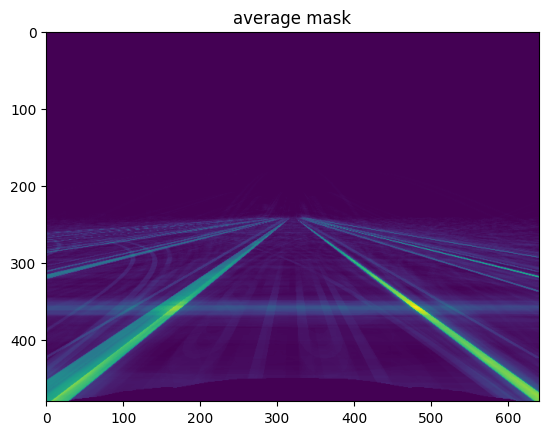

In [10]:
from matplotlib import pyplot as plt #to show images in this notebook
plt.imshow(avg_mask)
plt.title('average mask')
plt.show()

In [11]:
avg_mask


array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.2502, 0.2537, 0.2507, ..., 0.3403, 0.3452, 0.3457],
       [0.2546, 0.2487, 0.2507, ..., 0.3398, 0.3418, 0.3423],
       [0.2517, 0.2532, 0.2542, ..., 0.3403, 0.3398, 0.3423]],
      dtype=float16)

In [13]:
# code from Shima
def class_weighted_cross_entropy_loss(y_true,y_pred,class_weights):
    cross_entropy_loss = tf.keras.losses.binary_crossentropy(y_true,y_pred,from_logits=False)
    class_weights = tf.reshape(class_weights,[1,1,1,-1])
    weighterd_cross_entropy_loss = tf.reduce_mean(cross_entropy_loss * class_weights)
    return weighterd_cross_entropy_loss

In [14]:
class_weights = np.array([0.98,0.02])

In [15]:
test = tf.reshape(class_weights,[1,1,1,-1])

In [16]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', np.unique(x),x)
print(weights)

TypeError: too many positional arguments

In [3]:
# try weighted model
# Lane marking only
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # trying disabling GPU

import tensorflow as tf
import segmentation_models as sm
import time
import cv2
import random

import numpy as np
from matplotlib import pyplot as plt 
from keras import backend as K

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

SIZE_X = 640
SIZE_Y = 480

validation_portion = 0.2
sample_size_limit = 100

rgb_path = 'out_sem/rgb'
msk_path = 'out_sem/msk_ln'

'''
def class_weighted_cross_entropy_loss(y_true,y_pred):
    class_weights = np.array([0.98,0.02])
    cross_entropy_loss = tf.keras.losses.binary_crossentropy(y_true,y_pred,from_logits=False)
    class_weights = tf.cast(tf.reshape(class_weights,[1,-1]), tf.float32)
    tf.cast(cross_entropy_loss, tf.float32)
    weighterd_cross_entropy_loss = tf.reduce_mean(cross_entropy_loss * class_weights)
    return weighterd_cross_entropy_loss
'''

def weighted_binary_crossentropy( y_true, y_pred, weight=1. ) :
    y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
    logloss = -(y_true * K.log(y_pred) * weight + (1 - y_true) * K.log(1 - y_pred))
    return K.mean( logloss, axis=-1)

rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)

#reduce number of images here
rgb_images = rgb_images[0:sample_size_limit]

img_count = len(rgb_images)

train_len = int(img_count * (1-validation_portion))
val_len = img_count - train_len

x_train = np.zeros(shape=(train_len,SIZE_Y,SIZE_X,3),dtype=np.float16)
x_val = np.zeros(shape=(val_len,SIZE_Y,SIZE_X,3),dtype=np.float16)

y_train =  np.zeros(shape=(train_len,SIZE_Y,SIZE_X),dtype=np.float16)
y_val =  np.zeros(shape=(val_len,SIZE_Y,SIZE_X),dtype=np.float16)

i = 0
i_val = 0
for file in rgb_images:
        pth = os.path.join(rgb_path,file) 
        img = cv2.imread(pth,cv2.IMREAD_COLOR)
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,0)
        
        if i < train_len:
            x_train[i] = img/255
            y_train[i] = msk/255
        else:
            x_val[i_val] = img/255
            y_val[i_val] = msk/255
            i_val += 1
        
        i += 1
        
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# run without GPU
NAME = "UNET_LANES_WCE_LOSS-{}".format(int(time.time()))
#tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

model = sm.Unet(BACKBONE, encoder_weights=None)
model.load_weights(local_weights_path, by_name=True, skip_mismatch=True)
model.compile(optimizer='adam',loss=weighted_binary_crossentropy,metrics=['mse'])
#model.summary()


history = model.fit(x_train,y_train,batch_size=1,epochs=50,verbose=1,validation_data=(x_val,y_val))
model.save('model/{}'.format(NAME),save_format='tf')

Epoch 1/50
80/80 [==============================] - 23s 172ms/step - loss: 0.2511 - mse: 0.0664 - val_loss: 0.3999 - val_mse: 0.0248
Epoch 2/50
80/80 [==============================] - 13s 164ms/step - loss: 0.0547 - mse: 0.0098 - val_loss: 0.1204 - val_mse: 0.0245
Epoch 3/50
80/80 [==============================] - 13s 163ms/step - loss: 0.0364 - mse: 0.0077 - val_loss: 0.1250 - val_mse: 0.0244
Epoch 4/50
80/80 [==============================] - 13s 164ms/step - loss: 0.0286 - mse: 0.0064 - val_loss: 0.1316 - val_mse: 0.0245
Epoch 5/50
80/80 [==============================] - 13s 163ms/step - loss: 0.0240 - mse: 0.0056 - val_loss: 0.1328 - val_mse: 0.0246
Epoch 6/50
80/80 [==============================] - 13s 163ms/step - loss: 0.0214 - mse: 0.0051 - val_loss: 0.1457 - val_mse: 0.0247
Epoch 7/50
80/80 [==============================] - 13s 164ms/step - loss: 0.0199 - mse: 0.0049 - val_loss: 0.1505 - val_mse: 0.0247
Epoch 8/50
80/80 [==============================] - 13s 164ms/step - 

INFO:tensorflow:Assets written to: model/UNET_LANES_WCE_LOSS-1720030503\assets


INFO:tensorflow:Assets written to: model/UNET_LANES_WCE_LOSS-1720030503\assets


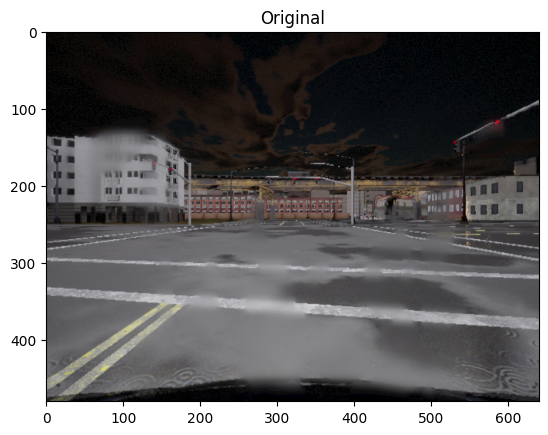

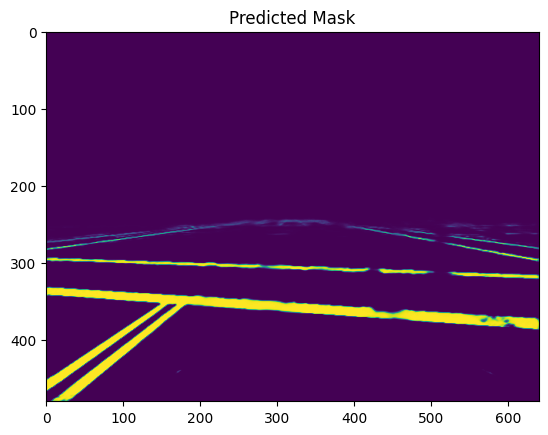

In [4]:
'''
import tensorflow as tf
from tensorflow.keras.models import load_model
import time
import cv2
import random
import os
import numpy as np
from matplotlib import pyplot as plt #to show images in this notebook

NAME = "UNET_LANES_WCE_LOSS-1680245747"
model = load_model("model/{}".format(NAME),compile=False)

'''
#get random rgn image
rgb_path = 'out_sem/rgb'
rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)
pth = os.path.join(rgb_path,rgb_images[3]) 
rgb_img = cv2.imread(pth,cv2.IMREAD_COLOR)

#make prediction of mask
img = np.float32(rgb_img /255)
input_for_model = img[ :, :, None] 
input_for_model = np.expand_dims(img, axis=0)
mask = model(input_for_model,training=False)
predicted_img = (np.squeeze(mask[0].numpy()) * 255)

rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)
plt.title('Original')
plt.show()

plt.imshow(predicted_img)
plt.title('Predicted Mask')
plt.show()


In [5]:
predicted_img.shape

(480, 640)

In [6]:
model.save('model/{}'.format(NAME),save_format='tf')

INFO:tensorflow:Assets written to: model/UNET_LANES_WCE_LOSS-1720030503\assets


INFO:tensorflow:Assets written to: model/UNET_LANES_WCE_LOSS-1720030503\assets


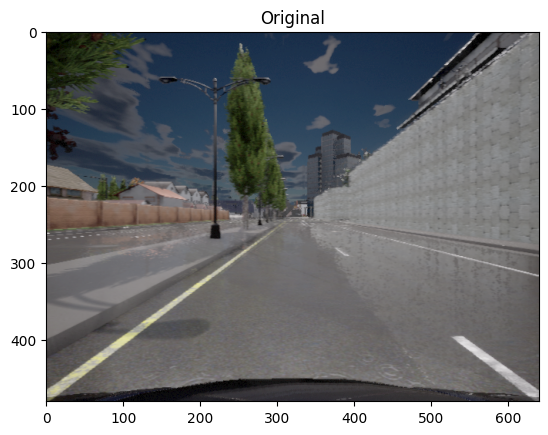

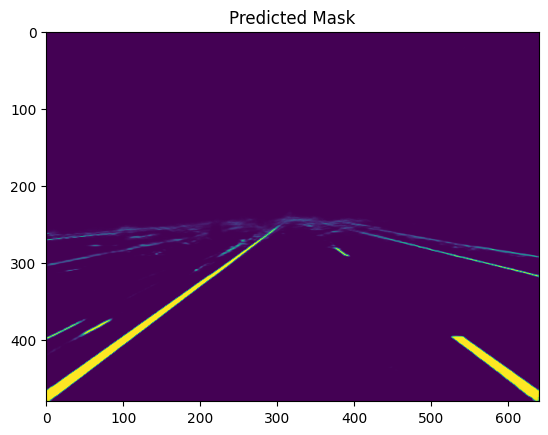

In [7]:
# test model with custom loss interrupted on 5th epoch "UNET_LANES_WCE_LOSS-1680304258"
#get random rgn image
rgb_path = 'out_sem/rgb'
rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)
pth = os.path.join(rgb_path,rgb_images[3]) 
rgb_img = cv2.imread(pth,cv2.IMREAD_COLOR)

#make prediction of mask
img = np.float32(rgb_img /255)
input_for_model = img[ :, :, None] 
input_for_model = np.expand_dims(img, axis=0)
mask = model(input_for_model,training=False)
predicted_img = (np.squeeze(mask[0].numpy()) * 255)

rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)
plt.title('Original')
plt.show()

plt.imshow(predicted_img)
plt.title('Predicted Mask')
plt.show()

In [6]:
#test on real Tesla video
# test model with custom loss interrupted on 5th epoch "UNET_LANES_WCE_LOSS-1680304258"
m3_video = cv2.VideoCapture('C:/SelfDrive/out_sem/tesla front camera example.mp4')

while(m3_video.isOpened()):
    # Capture frame-by-frame
    ret, frame = m3_video.read()
    if ret == True:
        # Display the resulting frameabs
        frame = cv2.resize(frame, (SIZE_X,SIZE_Y))
        frame = cv2.flip(frame, 1)
        img = np.float32(frame /255)
        input_for_model = img[ :, :, None] 
        input_for_model = np.expand_dims(img, axis=0)
        mask = model(input_for_model,training=False)
        final_mask = (np.squeeze(mask[0].numpy()) * 255)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        result = cv2.bitwise_and(gray,gray,mask = final_mask.astype(np.uint8))
        cv2.imshow('predicted mask',result)
        
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
 
        # Break the loop
    else: 
        break
# When everything done, release the video capture object
m3_video.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [3]:
# continue training weighted model
# Lane marking only
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # trying disabling GPU

import tensorflow as tf
import segmentation_models as sm
import time
import cv2
import random
from keras.models import load_model

import numpy as np
from matplotlib import pyplot as plt 
from keras import backend as K

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

SIZE_X = 640
SIZE_Y = 480

validation_portion = 0.2
sample_size_limit = 100

rgb_path = 'out_sem/rgb'
msk_path = 'out_sem/msk_ln'

def weighted_binary_crossentropy( y_true, y_pred, weight=1. ) :
    y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
    logloss = -(y_true * K.log(y_pred) * weight + (1 - y_true) * K.log(1 - y_pred))
    return K.mean( logloss, axis=-1)

rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)

#reduce number of images here
rgb_images = rgb_images[0:sample_size_limit]

img_count = len(rgb_images)

train_len = int(img_count * (1-validation_portion))
val_len = img_count - train_len

x_train = np.zeros(shape=(train_len,SIZE_Y,SIZE_X,3),dtype=np.float16)
x_val = np.zeros(shape=(val_len,SIZE_Y,SIZE_X,3),dtype=np.float16)

y_train =  np.zeros(shape=(train_len,SIZE_Y,SIZE_X),dtype=np.float16)
y_val =  np.zeros(shape=(val_len,SIZE_Y,SIZE_X),dtype=np.float16)

i = 0
i_val = 0
for file in rgb_images:
        pth = os.path.join(rgb_path,file) 
        img = cv2.imread(pth,cv2.IMREAD_COLOR)
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,0)
        
        if i < train_len:
            x_train[i] = img/255
            y_train[i] = msk/255
        else:
            x_val[i_val] = img/255
            y_val[i_val] = msk/255
            i_val += 1
        
        i += 1
        
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

NAME = "UNET_LANES_WCE_LOSS-1720030503"

model = load_model("model/{}".format(NAME),compile=False)

model.compile(optimizer='adam',loss=weighted_binary_crossentropy,metrics=['mse'])


history = model.fit(x_train,y_train,batch_size=1,epochs=50,verbose=1,validation_data=(x_val,y_val))
NAME_TO_SAVE = "UNET_LANES_WCE_LOSS_CONTD-{}".format(int(time.time()))
model.save('model/{}'.format(NAME_TO_SAVE),save_format='tf')

Epoch 1/50
80/80 [==============================] - 23s 170ms/step - loss: 0.0234 - mse: 0.0058 - val_loss: 0.0280 - val_mse: 0.0058
Epoch 2/50
80/80 [==============================] - 13s 162ms/step - loss: 0.0202 - mse: 0.0052 - val_loss: 0.0221 - val_mse: 0.0053
Epoch 3/50
80/80 [==============================] - 13s 163ms/step - loss: 0.0163 - mse: 0.0043 - val_loss: 0.0430 - val_mse: 0.0125
Epoch 4/50
80/80 [==============================] - 13s 164ms/step - loss: 0.0167 - mse: 0.0044 - val_loss: 0.0195 - val_mse: 0.0047
Epoch 5/50
80/80 [==============================] - 13s 165ms/step - loss: 0.0155 - mse: 0.0041 - val_loss: 0.0285 - val_mse: 0.0080
Epoch 6/50
80/80 [==============================] - 13s 167ms/step - loss: 0.0139 - mse: 0.0038 - val_loss: 0.0169 - val_mse: 0.0042
Epoch 7/50
80/80 [==============================] - 13s 166ms/step - loss: 0.0139 - mse: 0.0037 - val_loss: 0.0237 - val_mse: 0.0053
Epoch 8/50
80/80 [==============================] - 13s 167ms/step - 

INFO:tensorflow:Assets written to: model/UNET_LANES_WCE_LOSS_CONTD-1720032170\assets


INFO:tensorflow:Assets written to: model/UNET_LANES_WCE_LOSS_CONTD-1720032170\assets


In [3]:
# try GPU config
# Lane marking only
import os

import tensorflow as tf
import segmentation_models as sm
import time
import cv2
import random

import numpy as np
from matplotlib import pyplot as plt 
from keras import backend as K

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

SIZE_X = 640
SIZE_Y = 480

validation_portion = 0.2
sample_size_limit = 100

rgb_path = 'out_sem/rgb'
msk_path = 'out_sem/msk_ln'

def weighted_binary_crossentropy( y_true, y_pred, weight=1. ) :
    y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
    logloss = -(y_true * K.log(y_pred) * weight + (1 - y_true) * K.log(1 - y_pred))
    return K.mean( logloss, axis=-1)

rgb_images = os.listdir(rgb_path)
random.shuffle(rgb_images)

#reduce number of images here
rgb_images = rgb_images[0:sample_size_limit]

img_count = len(rgb_images)

train_len = int(img_count * (1-validation_portion))
val_len = img_count - train_len

x_train = np.zeros(shape=(train_len,SIZE_Y,SIZE_X,3),dtype=np.float16)
x_val = np.zeros(shape=(val_len,SIZE_Y,SIZE_X,3),dtype=np.float16)

y_train =  np.zeros(shape=(train_len,SIZE_Y,SIZE_X),dtype=np.float16)
y_val =  np.zeros(shape=(val_len,SIZE_Y,SIZE_X),dtype=np.float16)

i = 0
i_val = 0
for file in rgb_images:
        pth = os.path.join(rgb_path,file) 
        img = cv2.imread(pth,cv2.IMREAD_COLOR)
        pth = os.path.join(msk_path,file) 
        msk = cv2.imread(pth,0)
        
        if i < train_len:
            x_train[i] = img/255
            y_train[i] = msk/255
        else:
            x_val[i_val] = img/255
            y_val[i_val] = msk/255
            i_val += 1
        
        i += 1
        
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

NAME = "UNET_LANES_WCE_LOSS-{}".format(int(time.time()))
model = sm.Unet(BACKBONE, encoder_weights=None)
model.load_weights(local_weights_path, by_name=True, skip_mismatch=True)
model.compile(optimizer='adam',loss=weighted_binary_crossentropy,metrics=['mse'])


history = model.fit(x_train,y_train,batch_size=1,epochs=50,verbose=1,validation_data=(x_val,y_val))
model.save('model/{}'.format(NAME),save_format='tf')

Epoch 1/50
80/80 [==============================] - 22s 169ms/step - loss: 0.0945 - mse: 0.0196 - val_loss: 0.1080 - val_mse: 0.0210
Epoch 2/50
80/80 [==============================] - 13s 163ms/step - loss: 0.0384 - mse: 0.0085 - val_loss: 0.1078 - val_mse: 0.0204
Epoch 3/50
80/80 [==============================] - 22s 282ms/step - loss: 0.0319 - mse: 0.0073 - val_loss: 0.1186 - val_mse: 0.0205
Epoch 4/50
80/80 [==============================] - 13s 165ms/step - loss: 0.0239 - mse: 0.0058 - val_loss: 0.1285 - val_mse: 0.0205
Epoch 5/50
80/80 [==============================] - 13s 160ms/step - loss: 0.0312 - mse: 0.0078 - val_loss: 0.1577 - val_mse: 0.0206
Epoch 6/50
80/80 [==============================] - 13s 160ms/step - loss: 0.0323 - mse: 0.0079 - val_loss: 0.1583 - val_mse: 0.0206
Epoch 7/50
80/80 [==============================] - 43s 544ms/step - loss: 0.0238 - mse: 0.0059 - val_loss: 0.1201 - val_mse: 0.0204
Epoch 8/50
52/80 [==================>...........] - ETA: 29s - loss: 

KeyboardInterrupt: 